# Program in the CTH Trigger Logic

In [10]:
import sys
sys.path.insert(0, '../../modules')
%pylab inline
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib


In [11]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as mtick
from hits import CyDetHits, CTHHits, CDCHits
import visualizations as viz
import pandas as pd
from cylinder import CDC

## Import Data

In [12]:
# Test on signal or background data files
test_sig = True
#SignalTracks/output/0001/oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root
#SignalTracks/output/0001/oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal.root

In [13]:
cth_sig_file = "/home/five4three2/development/ICEDUST/track-finding-yandex/data/old_samples/oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root"
cdc_sig_file = "/home/five4three2/development/ICEDUST/track-finding-yandex/data/old_samples/oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root"
a_file = "/home/five4three2/development/ICEDUST/track-finding-yandex"+\
         "/data/MC4q/8e6_pot/bunch_train_6/root/MC4q_bkg_f5_b6_t-100_2000.root"

# CTH Plots

In [14]:
vol_id_name = "CTHHit.fvol_id"
x_pos_name = "CTHHit.fMCPos.fP.fX"
y_pos_name = "CTHHit.fMCPos.fP.fY"
z_pos_name = "CTHHit.fMCPos.fP.fZ"
t_pos_name = "CTHHit.fMCPos.fE"
#hits.cth.data[x_pos_name] = - (hits.cth.data[x_pos_name]/10. - 765)
#hits.cth.data[y_pos_name] = hits.cth.data[y_pos_name]/10.

In [15]:
cdc_vol_id_name = "CDCHit.fvol_id"
cdc_x_pos_name = "CDCHit.fMCPos.fP.fX"
cdc_y_pos_name = "CDCHit.fMCPos.fP.fY"
cdc_z_pos_name = "CDCHit.fMCPos.fP.fZ"
cdc_t_pos_name = "CDCHit.fMCPos.fE"
#hits.cdc.data[cdc_x_pos_name] = - (hits.cdc.data[cdc_x_pos_name]/10. - 765)
#hits.cdc.data[cdc_y_pos_name] = hits.cdc.data[cdc_y_pos_name]/10.
#hits.cdc.data[cdc_z_pos_name] = (hits.cdc.data[cdc_z_pos_name]/10. - 641)

In [16]:
def get_crystal_coincidence(vol_types, geom):
    
    return np.logical_or(hit_and_left, hit_and_right)

# New Algorithm Using DataFrame

In [17]:
h_cth = CTHHits(a_file, 
                tree="CTHHitTree",
                branches=["MCPos.fP.fX","MCPos.fP.fY","MCPos.fP.fZ","EventNumber"])
h_cth.rebin_time()

In [9]:
h_cth.set_trigger_hits(n_proc=2)

Using  2


ValueError: zero-dimensional arrays cannot be concatenated

In [25]:
def scan_trigger_windows(x, t_window_ns=50, t_delta_ns=10):
    # Skip if its empty or if its too small
    if x.shape[0] < h_cth.trig_patterns.shape[1]:
        return None
    # Get the time units needed
    t_window = pd.Timedelta(nanoseconds=t_window_ns)
    # Iterate over the ranges and get the absolute minimum time if any
    min_time_pattern = (None, None, None)
    for t_start in np.arange(0, t_window_ns, t_delta_ns):
        # Get the trigger sets in this group
        trig_set = x.groupby(pd.Grouper(key=h_cth.time_name, 
                                        freq=t_window,
                                        base=t_start)).apply(find_trigger_signal).values
        # Iterate through the results
        for trigger in filter(None, trig_set):
            # Check if we have a new minimum time trigger
            if (min_time_pattern[0] is None) or (trigger[0] < min_time_pattern[0]):
                min_time_pattern = trigger
    # Return the hit indexes that form the minimum
    return min_time_pattern[2]
        
# Find the actual trigger signal
def find_trigger_signal(x):
    # Skip if its empty or if its too small
    if x.shape[0] < h_cth.trig_patterns.shape[1]:
        return None
    # Volume ids and hit times
    vol_ids = x[h_cth.flat_name]
    hit_times = x[h_cth.time_name]
    hit_indexes = x.index.get_level_values(h_cth.hit_index)
    # Get if the trigger sets are found in the volume ids
    found_vols = np.isin(h_cth.trig_patterns, vol_ids)
    # Check that atleast 4 match
    full_patterns = np.sum(found_vols, axis=1) == h_cth.trig_patterns.shape[1]
    # Return nothing if nothing found
    if not np.any(full_patterns):
        return None
    # Find the minimum time across all patterns
    min_time_pattern = (pd.Timestamp.max, None, None)
    for pattern in h_cth.trig_patterns[full_patterns]:
        # Check which hits made the pattern in this group
        hit_ids = np.in1d(vol_ids, pattern)
        # Find their minimum time
        min_time = np.amin(hit_times[hit_ids])
        # Set this to the return value if needed
        if min_time_pattern[0] > min_time:
            min_time_pattern = (min_time, pattern, hit_indexes[hit_ids].values)
    # Map this back to the ids of the found pattern
    return min_time_pattern

In [27]:
# Group by event and look for the signal pattern
h_cth.data[h_cth.time_name] = pd.to_datetime(h_cth.data[h_cth.time_name], unit="ns")
grouped_data = h_cth.data.groupby([h_cth.event_index])
grouped_data = grouped_data[[h_cth.flat_name,
                             h_cth.time_name]].apply(scan_trigger_windows)
trigger_hit_indexes = np.concatenate(grouped_data.dropna().values)

KeyboardInterrupt: 

In [28]:
print(h_cth.n_hits/h_cth.n_events)
print(h_cth.n_hits, h_cth.n_events)

179.9849
1799849 10000


In [29]:
from multiprocessing import Pool, cpu_count

In [30]:
h_cth.data.dtypes

CTHHit.fCharge                float32
CTHHit.fIsSig                    bool
CTHHit.fMCPos.fE       datetime64[ns]
CTHHit.fMCPos.fP.fX           float32
CTHHit.fEventNumber             int32
CTHHit.fMCPos.fP.fZ           float32
CTHHit.fMCPos.fP.fY           float32
CTHHit.fvol_id                 uint16
dtype: object

In [32]:
def parallel_grouby(grouped_data, func):
    # Open up a pool of cputs
    with Pool(cpu_count()) as pool:
        ret_list = pool.map(func, [group for _, group in grouped_data])
    # Return the values
    return [item for item in ret_list if item is not None]
# Denote the variable list
var_list = [h_cth.flat_name,
            h_cth.time_name]
# Group the data
grouped_data = h_cth.data.groupby([h_cth.event_index])[[h_cth.flat_name, h_cth.time_name]]
ret_values = parallel_grouby(grouped_data, scan_trigger_windows)
trigger_hit_indexes_par = np.concatenate(ret_values)

Process ForkPoolWorker-41:
Process ForkPoolWorker-30:
Process ForkPoolWorker-47:
Process ForkPoolWorker-56:
Process ForkPoolWorker-58:
Process ForkPoolWorker-49:
Process ForkPoolWorker-53:
Process ForkPoolWorker-57:
Process ForkPoolWorker-55:
Process ForkPoolWorker-42:
Process ForkPoolWorker-54:
Process ForkPoolWorker-46:
Process ForkPoolWorker-52:
Process ForkPoolWorker-44:
Process ForkPoolWorker-36:
Process ForkPoolWorker-51:
Process ForkPoolWorker-45:
Process ForkPoolWorker-48:
Process ForkPoolWorker-50:
Process ForkPoolWorker-39:
Process ForkPoolWorker-29:
Process ForkPoolWorker-43:
Process ForkPoolWorker-38:
Traceback (most recent call last):
Process ForkPoolWorker-59:
Process ForkPoolWorker-37:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Process ForkPoolWorker-28:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-40:
Traceback (most recent call last):
Traceback (most

  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fi

  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()

  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 242, in __new__
    result._verify_integrity()
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 281, in _verify_integrity
    if not level.is_unique:
KeyboardInterrupt
KeyboardInterrupt
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 242, in __new__
    result._verify_integrity()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-33:
  File "/home/five4three2/development/miniconda

  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 306, in _set_levels
    for lev in levels)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 1440, in rename
    return self.set_names([name], inplace=inplace)
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/multi.py", line 306, in <genexpr>
    for lev in levels)
KeyboardInterrupt
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/numeric.py", line 70, in _shallow_copy
    **kwargs))
  File "/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 510, in _shallow_copy
    @Appender(_index_shared_docs['_shallow_copy'])
KeyboardInterrupt


KeyboardInterrupt: 

In [1]:
%%time
trigger_hit_indexes_seq = h_cth.get_trigger_hits()

NameError: name 'h_cth' is not defined

In [74]:
np.testing.assert_allclose(trigger_hit_indexes, trigger_hit_indexes_par)

In [94]:
geom = CDC()

/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The frac parameter was deprecated in version 2.1. Use tick padding via Axes.tick_params instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


AttributeError: 'Int64Index' object has no attribute 'levels'

/home/five4three2/development/miniconda3/envs/tfy3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


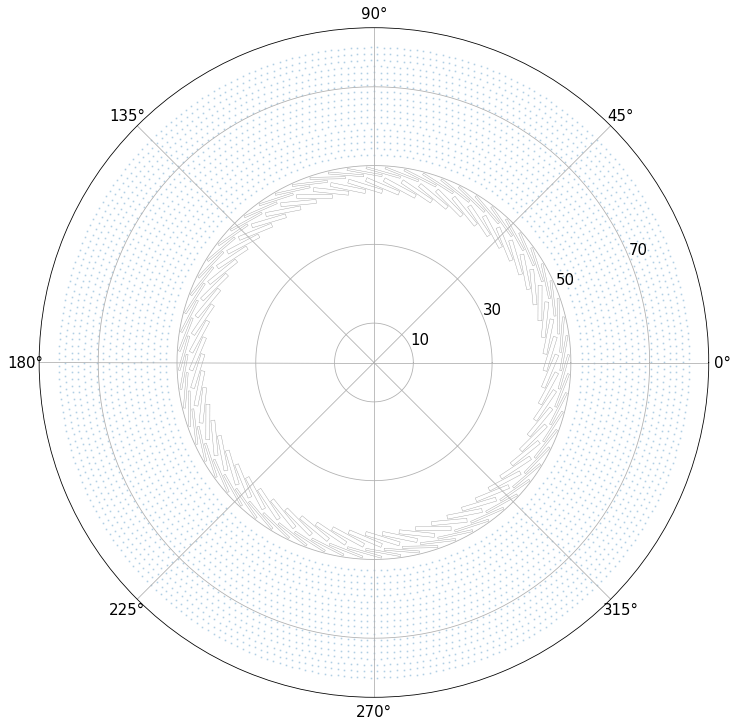

In [118]:
for evt in range(10):
    # Plot the output
    viz.plot_output(np.zeros(geom.n_points), geom)
    # Add volume outlines
    viz.plot_add_cth_outlines(h_cth.geom)
    # Add the CTH vols with hits
    cth_vol_types = h_cth.get_vol_types(evt)
    print(np.where(cth_vol_types))
    viz.plot_add_cth(cth_vol_types, cth_vol_types, h_cth.geom)
    plt.show()

In [142]:
def get_trigger_signal(cth, geom):
    # Get all volumes with pairs
    hit_and_left = np.logical_and(vol_types, vol_types[geom.shift_wires(1)])
    hit_and_right = np.logical_and(vol_types, vol_types[geom.shift_wires(-1)])
    trig_crys = np.logical_or(hit_and_left, hit_and_right)
    # Get volumes with crystals hit above or below
    on_top = np.logical_and(trig_crys[geom.cher_crys], 
                            trig_crys[geom.scin_crys])
    trig_crys[geom.cher_crys] = on_top
    trig_crys[geom.scin_crys] = on_top
    # Include the crystals to the left and right of these volumes
    trig_crys = np.logical_or.reduce((trig_crys, 
                                      trig_crys[geom.shift_wires(1)],
                                      trig_crys[geom.shift_wires(-1)]))
    # Return the volumes that pass and have hits
    return np.logical_and(vol_types, trig_crys)    

In [20]:
hits.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fE
CTHHit.fMCPos.fP.fY
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fMCPos.fP.fX
CTHHit.fCharge
CTHHit.fMCPos.fP.fZ
CTHHit.fvol_id
CDC Branches:
Branches available are:
CDCHit.fChannel
CDCHit.fEventNumber
CDCHit.fMCPos.fP.fZ
CDCHit.fCharge
CDCHit.fMCPos.fP.fY
CDCHit.fIsSig
CDCHit.fMCPos.fE
CDCHit.fMCPos.fP.fX
CDCHit.fDetectedTime


In [21]:
def set_trigger_vols(cth_hits, event):
    # Get the volumes with hits for these events
    cth_vol_types = cth_hits.get_vol_types(event)
    vols_with_trig = np.nonzero(get_trigger_signal(cth_vol_types, cth_hits.geom))
    vol_trig_hits = cth_hits.filter_hits(cth_hits.get_events(event), "CTHHit.fvol_id", 
                                         values=vols_with_trig)["CTHHit.fhits_index"]
    # Get the timing of the fourth volume hit
    if sum(vols_with_trig) != 0:
        _, uniq_idxs = np.unique(cth_hits.data["CTHHit.fvol_id"][vol_trig_hits], 
                                   return_index=True)
        print(uniq_idxs)
        uniq_idxs = uniq_idxs[uniq_idxs > 2] 
        print(uniq_idxs)
        fourth_uniq_hit = uniq_idxs[(np.abs(uniq_idxs-3)).argmin()]
        print(fourth_uniq_hit)
        fourth_vol_hit = vol_trig_hits[fourth_uniq_hit]
        cth_hits.data["CTHHit.fTrigTime"][vol_trig_hits] = cth_hits.data[cth_hits.time_name][fourth_vol_hit]

In [22]:
hits.cth.set_trigger_time()

../../modules/hits.py:1012: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data[self.time_name][fourth_vol_hit]


KeyboardInterrupt: 

In [ ]:
print(hits.cth.get_vol_types(10)[:None])
print(hits.cth.get_trig_vector(10)[0])

In [ ]:
np.where(hits.cth.get_trig_vector(0)[0] == 1.)

In [ ]:
for evt in range(10):
    # Plot the output
    #viz.plot_output(np.zeros_like(hits.cdc.get_hit_types(evt)), geom)
    # Add hit outlines
    #viz.plot_add_outlines(hits.cdc.get_hit_types(evt), geom)
    # Add volume outlines
    #viz.plot_add_cth_outlines(hits.cth.geom)
    # Add the CTH vols with hits
    #cth_vol_types = hits.cth.get_vol_types(evt)
    #viz.plot_add_cth(cth_vol_types, hits.cth.get_trig_vector(evt)[0], hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    cdc_hits = hits.cdc.get_events(evt)
    print(evt,
          np.unique(cth_hits["CTHHit.fEventNumber"]),
          np.unique(cth_hits["CTHHit.fEventNumber"]))
    plt.title("XvY")
    plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, color="green")
    plt.scatter(cdc_hits[cdc_x_pos_name], cdc_hits[cdc_y_pos_name], s=1, color="blue")
    plt.show()
    plt.scatter(cth_hits[x_pos_name], cth_hits[z_pos_name], s=1, color="green")
    plt.scatter(cdc_hits[cdc_x_pos_name], cdc_hits[cdc_z_pos_name], s=1, color="blue")
    plt.title("XvZ")
    plt.show()
    plt.scatter(cth_hits[y_pos_name], cth_hits[z_pos_name], s=1, color="green")
    plt.scatter(cdc_hits[cdc_y_pos_name], cdc_hits[cdc_z_pos_name], s=1, color="blue")
    plt.title("YvZ")
    plt.show()

In [ ]:
print hits.cth.get_events(events=12)[hits.cth.time_name]